In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from skimage import io, transform
import scipy.misc as m
from tqdm import tqdm
import shutil
import tensorflow as tf
from tensorflow.contrib.data import Dataset, Iterator

In [ ]:
# Preparing the dataset
data_dir = '/Users/navneetmkumar/Desktop/TUM/lfw'
users = os.listdir(data_dir)
print(len(users))
users = sorted(users[1:])

In [2]:
root_dir = '/Users/navneetmkumar/Desktop/TUM/'
image_dir = root_dir+ 'lfw/'

if not os.path.exists(root_dir+'train-inputs'):
    os.makedirs(root_dir+'train-inputs')

if not os.path.exists(root_dir+'train-targets'):
    os.makedirs(root_dir+'train-targets')
    
if not os.path.exists(root_dir+'train-inputs-small'):
    os.makedirs(root_dir+'train-inputs-small')

if not os.path.exists(root_dir+'train-targets-small'):
    os.makedirs(root_dir+'train-targets-small')

# Getting the data into a single training folder
def create_training_set(users, root_dir, image_dir):
    for user in users[1:]:
        path = os.path.join(image_dir, user)
        for f in os.listdir(path):
            f_name = os.path.basename(f)
            f_name = f_name.split(".")[0]
            f = os.path.join(path, f)
            img = cv2.imread(f)
            resized_image=cv2.resize(img,(50,50)) 
            cv2.imwrite(root_dir+'train-inputs-small/'+f_name+".jpg",resized_image)

In [ ]:
create_training_set(users, root_dir, image_dir)

In [3]:
train_dir = root_dir+'train-inputs-small/'
# Creating the targets dataset
def create_targets_set(train_dir):
    for f in sorted(os.listdir(train_dir)):
        f_name = os.path.join(train_dir+f)
        img = io.imread(f_name)
        # Make the transformation (Gaussian Blur)
        blur = cv2.GaussianBlur(img, (7,7), 0)
        io.imsave(root_dir+'train-targets-small/'+f,blur)

In [ ]:
create_targets_set(train_dir)

In [4]:
print(len(os.listdir(train_dir)))

13232


In [5]:
train_targets_dir = root_dir+'train-targets-small/'
print(len(os.listdir(train_targets_dir)))

13232


In [6]:
train_imgs = os.listdir(train_dir)
train_targets = os.listdir(train_targets_dir)

In [27]:
# Defining the global variables
IMG_SIZE = 50
# Constants describing the training process.
MOVING_AVERAGE_DECAY = 0.9999     
NUM_EPOCHS_PER_DECAY = 350.0      
LEARNING_RATE_DECAY_FACTOR = 0.1  
INITIAL_LEARNING_RATE = 0.1       

# Creating the model

batch_size= 4

def GaussianFilterModel(data):
    
    
    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = tf.get_variable('w------1', [5,5,3,64], initializer=tf.truncated_normal_initializer(5e-2), dtype=tf.float32)
        conv = tf.nn.conv2d(data, kernel, [1,1,1,1], padding='SAME')
        biases = tf.get_variable('b------2', [64], initializer=tf.constant_initializer(0.1), dtype=tf.float32)
        pre_activation = tf.nn.bias_add(conv, biases)
        act = tf.nn.relu(pre_activation, name=scope.name)
        
        #norm
        norm = tf.nn.lrn(act, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm')
        
        #pool
        pool = tf.nn.max_pool(norm, ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1], padding='SAME', name='pool')
        
    with tf.variable_scope('conv4') as scope:
        
        kernel4 = tf.get_variable('w------3', [1,1,64, 3], initializer=tf.truncated_normal_initializer(5e-2), dtype=tf.float32)
        conv4 = tf.nn.conv2d(pool, kernel4, [1,1,1,1], padding='SAME')
        biases4 = tf.get_variable('b------3', [3], initializer=tf.constant_initializer(0.1), dtype=tf.float32)
        pre_activation4 = tf.nn.bias_add(conv4, biases4)
        
    
    with tf.variable_scope('local1') as scope:
        output = tf.image.resize_images(pre_activation4, tf.Variable([50, 50], tf.int32))
        output = tf.nn.softmax(output)
        output = tf.multiply(output, 255, name='operation_to_restore')
        
    return output
        

In [8]:
#validation split
validation_size = 0.2
# Input data
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE, IMG_SIZE, 3], name='x')
y = tf.placeholder(tf.float32, shape=[None, IMG_SIZE, IMG_SIZE, 3], name='y')

In [9]:
train_images = []
for f in train_imgs:
    f_name = train_dir+f
    train_images.append(f_name)

In [10]:
train_labels = []
for f in train_targets:
    f_name = train_targets_dir + f
    train_labels.append(f_name)

In [11]:
train_images = train_images[0:1200]
print(len(train_images))

1200


In [12]:
train_labels = train_labels[0:1200]
print(len(train_labels))
def input_parser(image_path, label_path):
    img_file = tf.read_file(image_path)
    label_file = tf.read_file(label_path)
    img_decoded = tf.image.decode_image(img_file, channels=3)
    lbl_decoded = tf.image.decode_image(label_file, channels=3)
    
    return img_decoded, lbl_decoded

1200


In [ ]:
print(train_images[-10:]) 
print(train_labels[-10:])

In [ ]:
tr_data = Dataset.from_tensor_slices((train_images, train_labels))
tr_data = tr_data.map(input_parser)
tr_data = tr_data.batch(batch_size)
# create TensorFlow Iterator object
iterator = Iterator.from_structure(tr_data.output_types,
                                   tr_data.output_shapes)
next_element = iterator.get_next()

# create two initialization ops to switch between the datasets
training_init_op = iterator.make_initializer(tr_data)

In [28]:
# Define the training 
def train_model(x, y):
    prediction = GaussianFilterModel(x)
    cost = tf.reduce_mean(tf.losses.mean_pairwise_squared_error(y, prediction))
    optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)
    
    hm_epochs = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(hm_epochs):
            #sess.run(training_init_op)
            epoch_loss = 0
            #while True:
             #   try:
            #      elem = sess.run(next_element)
            #        epoch_x, epoch_y = elem
            #        _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
            #        epoch_loss += c
            #        
            #    except tf.errors.OutOfRangeError:
            #        break
            
            for epoch_x, epoch_y in zip(train_images, train_labels):
                epoch_x = io.imread(epoch_x)
                epoch_y = io.imread(epoch_y)
                _, c = sess.run([optimizer, cost], feed_dict={x:[epoch_x], y:[epoch_y]})
                epoch_loss += c
            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
        
        # Save the session
        saver = tf.train.Saver()
        saver.save(sess, 'my_test_model_2')

In [29]:
train_model(x, y)

Epoch 0 completed out of 100 loss: 40644758.5938
Epoch 1 completed out of 100 loss: 22328564.375
Epoch 2 completed out of 100 loss: 13243853.1635
Epoch 3 completed out of 100 loss: 9750277.74634
Epoch 4 completed out of 100 loss: 9254782.36353
Epoch 5 completed out of 100 loss: 9340876.92407
Epoch 6 completed out of 100 loss: 10109339.965
Epoch 7 completed out of 100 loss: 9299548.89148
Epoch 8 completed out of 100 loss: 9064981.01489
Epoch 9 completed out of 100 loss: 9040886.64807
Epoch 10 completed out of 100 loss: 10290666.6674
Epoch 11 completed out of 100 loss: 8971648.02417
Epoch 12 completed out of 100 loss: 8855634.97803
Epoch 13 completed out of 100 loss: 8982213.11584
Epoch 14 completed out of 100 loss: 8957714.7793
Epoch 15 completed out of 100 loss: 9161010.50427
Epoch 16 completed out of 100 loss: 8763186.15723
Epoch 17 completed out of 100 loss: 8883537.7019
Epoch 18 completed out of 100 loss: 8327715.39893
Epoch 19 completed out of 100 loss: 8760836.1123
Epoch 20 comple

In [30]:
# Load the saved tensorflow model
sess = tf.Session()
root_dir = '/Users/navneetmkumar/Desktop/TUM/'
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(root_dir+'my_test_model_2.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./my_test_model_2


INFO:tensorflow:Restoring parameters from ./my_test_model_2


In [31]:
graph = tf.get_default_graph()
x = graph.get_tensor_by_name('x:0')

None


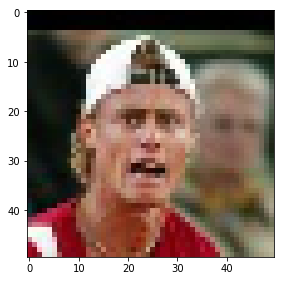

In [34]:
img_path = train_images[90]
img = io.imread(img_path)
img_file = tf.read_file(img_path)
img_decoded = tf.image.decode_image(img_file, channels=3)
feed_dict = {x: [img]}
op_to_restore = graph.get_operation_by_name('local1/operation_to_restore')
p = sess.run(op_to_restore, feed_dict)
print(p)

In [ ]:
for o in graph.get_operations():
    print(o)